<a href="https://colab.research.google.com/github/zhiyuan-95/DP-LRA/blob/main/dp_lra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import math
import time
import matplotlib.pyplot as plt

In [2]:
# gpt's code
def pstable(alpha, size=1):
    """
    Returns 'size' samples from a centered, symmetric alpha-stable distribution
    (a.k.a. p-stable). Uses the Chambers–Mallows–Stuck (CMS) method.

    alpha = stability parameter in (0, 2].
            - alpha=2 => Normal(0, 2)
            - alpha=1 => Cauchy(0,1)
            - else    => general alpha-stable
    size  = integer or tuple for shape of output samples
    """
    if alpha <= 0 or alpha > 2:
        raise ValueError("alpha must be in (0, 2].")

    # Special case: Gaussian
    if np.isclose(alpha, 2.0):
        # Note: for scale=1 alpha-stable with alpha=2, variance = 2.0
        # so stdev is sqrt(2).
        return np.sqrt(2.0)*np.random.randn(*np.atleast_1d(size))

    # Special case: Cauchy
    if np.isclose(alpha, 1.0):
        # Cauchy(0, 1)
        # which is tan(U) with U ~ Uniform(-pi/2, pi/2)
        U = np.random.uniform(-0.5*np.pi, 0.5*np.pi, size=size)
        return np.tan(U)

    # General case: Chambers–Mallows–Stuck
    U = np.random.uniform(-0.5*np.pi, 0.5*np.pi, size=size)
    W = np.random.exponential(1.0, size=size)

    # The standard formula for symmetric alpha-stable, location=0, scale=1, beta=0:
    # X = ( sin(alpha * U) / (cos(U))^(1/alpha) ) *
    #     [ cos( U*(1-alpha) ) / W ] ^( (1-alpha)/alpha )
    # (valid for alpha != 1)
    part1 = np.sin(alpha * U) / (np.cos(U)**(1.0/alpha))
    # to avoid potential sign issues, we typically keep the sign from cos((1-alpha)*U)
    # but this is the standard formula
    part2 = ( np.cos((1.0 - alpha)*U) / W )**((1.0 - alpha)/alpha)
    return part1 * part2

def D(n, d, alpha):
    """
    Returns an (n x d) NumPy array of i.i.d. alpha-stable samples
    from the CMS method.
    """
    return pstable(alpha, size=(n, d))


In [ ]:
def optimal_rank_k(X,k):
  U,S,VT = np.linalg.svd(X,full_matrices=False)
  return U[:,:k]@np.diag(S[:k])@VT[:k,:]

In [ ]:
def initialize(n,d,p,k,delta,epsilon,s,t,phi,psi):
  # generate p stable RV
  s=math.ceil(k*np.log(k)*np.log(1/delta)*s)
  t= math.ceil(k*np.log(k)*np.log(1/delta)*t)
  phi= math.ceil(k*np.log(k)*np.log(1/delta)*phi)
  psi= math.ceil(k*np.log(k)*np.log(1/delta)*psi)
  Phi, Psi, S, T = D(phi,n, p), D(d,psi, p), D(s,n,p), D(d,t,p)
  # noise
  C_phi = Cs = np.log(n)
  C_psi = Ct = np.log(d)
  N_1 = np.random.laplace(0,C_phi/epsilon,(phi,d))
  N_2 = np.random.laplace(0,C_psi/epsilon,(n,psi))
  N_3 = np.random.laplace(0,C_phi*C_psi/epsilon,(s,t))
  return Phi,Psi,S,T,N_1,N_2,N_3

In [ ]:
def sketch1(A,Psi,Phi,N_1,N_2):
  Yc = A@Psi+N_2
  Yr = Phi@A+N_1
  return Yc,Yr
def sketch2(A,Yr,Yc,S,T,N_3):
  Zc, Zr = S@Yc, Yr@T
  Z = S@A@T+N_3
  return Zc,Zr,Z
def SVD(Zc,Zr):
  Uc,Sigma_c,Vc_T = np.linalg.svd(Zc, full_matrices=False)
  Ur,Sigma_r,Vr_T = np.linalg.svd(Zr, full_matrices=False)
  Sigma_c,Sigma_r = np.diag(Sigma_c),np.diag(Sigma_r)
  Vc,Vr = Vc_T.T,Vr_T.T
  return Sigma_c,Sigma_r,Uc,Ur,Vc,Vr

In [ ]:
def l2_LRA(Uc,Ur,Vc,Vr,Sigma_c,Sigma_r,Z,k):
  mid_part = optimal_rank_k(Uc.T@Z@Vr,k)
  return Vc@np.linalg.pinv(Sigma_c)@mid_part@np.linalg.pinv(Sigma_r)@Ur.T

In [ ]:
#e- epsilon: privacy parameter
def algorithm1(A,p,k,delta,epsilon,s,t,phi,psi):
  Phi,Psi,S,T,N_1,N_2,N_3 = initialize(A.shape[0],A.shape[1],p,k,delta, epsilon,s,t,phi,psi)
  Yc,Yr = sketch1(A,Psi,Phi,N_1,N_2)
  Zc,Zr,Z = sketch2(A,Yr,Yc,S,T,N_3)
  Sigma_c,Sigma_r,Uc,Ur,Vc,Vr = SVD(Zc,Zr)
  X_hat = l2_LRA(Uc,Ur,Vc,Vr,Sigma_c,Sigma_r,Z,k)
  M = Yc@X_hat@Yr
  return M

In [ ]:
def generate_A(n,d):
  U_A, _ = np.linalg.qr(np.random.randn(n,d))
  V_A, _ = np.linalg.qr(np.random.randn(d,d))

  # Create the diagonal matrix S
  S_A = np.diag(sorted((np.log(n)**(6*np.random.rand(d))-1)/10000, reverse=True))

  # Compute the product A = U * S * V
  A = U_A @ S_A @ V_A.T
  return A, U_A, S_A, V_A.T

In [ ]:
def p_norm(M,p):
  return np.sum(np.power(np.abs(M),p))**(1/p)

In [ ]:
def relative_error(A,U_A,S_A,V_A_T, M):
  A_k = U_A[:,:k]@S_A[:k,:k]@V_A_T[:k,:]
  error = p_norm(A-M,p)
  error_opt =p_norm(A-A_k,p)
  relative_error = error/error_opt
  return relative_error #error,error_opt
def total_error(A,M):
  return p_norm(A-M,p)

In [ ]:
#configuration
n,d = 2000,2000
A,U_A,S_A,V_A_T = generate_A(n,d)

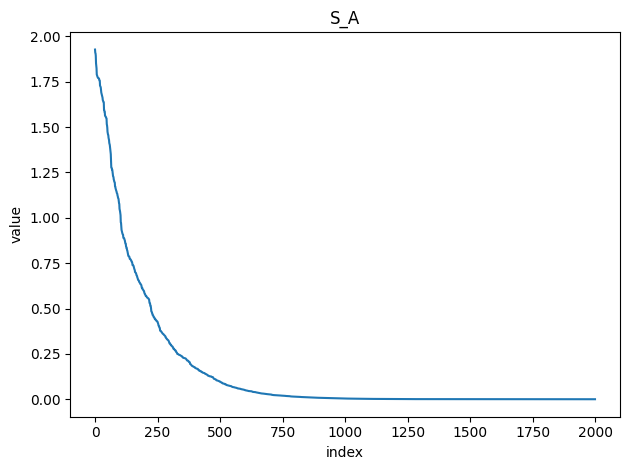

In [ ]:
plt.plot(sorted((np.log(n)**(6*np.random.rand(d))-1)/100000, reverse=True))
plt.xlabel('index')
plt.ylabel('value')
plt.title('S_A')
plt.tight_layout()
plt.show()

In [ ]:
epsilon = 0.01 # privacy parameter
k = int(0.05*d) # rank that we want to preserve
p = 1.5 #p-norm
delta = 0.05 #failure probability
s,t,phi,psi = 0.2,0.2, 1,1
M = algorithm1(A,p,k,delta,epsilon,s,t,phi,psi)
relative_error(A,U_A,S_A,V_A_T, M)

np.float64(2.6539996675547326)

In [ ]:
k*np.log(k)*np.log(1/delta)

np.float64(1379.585695137316)

privacy parameter and error

In [ ]:
r_error = []
t_error = []
eps_lst = [round(0.01+i*0.005, 3) for i in range(15)]
time_cost = []
for epsilon in eps_lst:
  time_start = time.time()
  M = algorithm1(A,p,k,delta,epsilon,s,t,phi,psi)
  time_end = time.time()
  r_error.append(relative_error(A,U_A,S_A,V_A_T, M))
  t_error.append(total_error(A,M))
  time_cost.append(time_end-time_start)

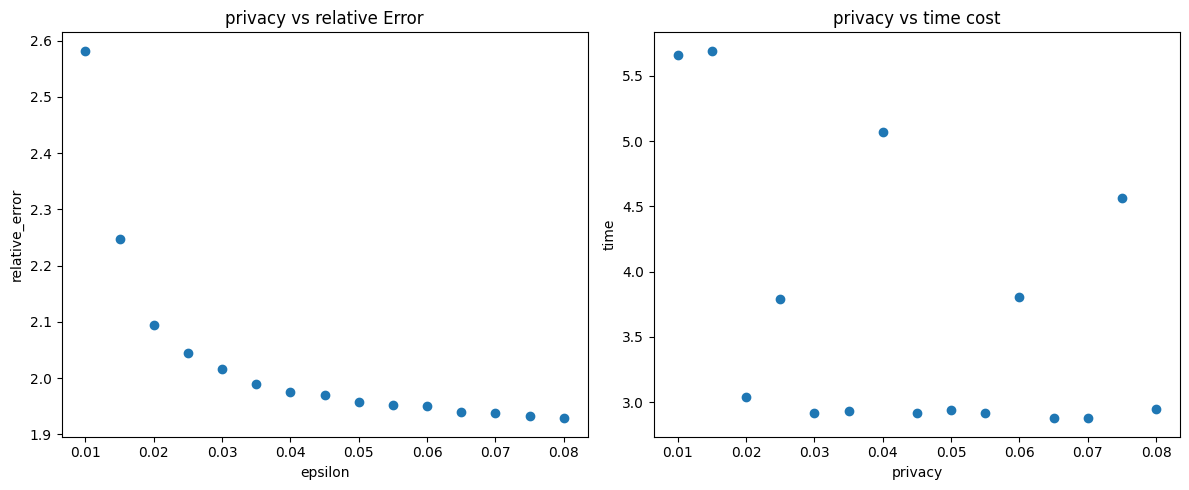

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].scatter(eps_lst, r_error)
axs[0].set_xlabel('epsilon')
axs[0].set_ylabel('relative_error')
axs[0].set_title('privacy vs relative Error')

axs[1].scatter(eps_lst, time_cost)
axs[1].set_xlabel('privacy')
axs[1].set_ylabel('time')
axs[1].set_title('privacy vs time cost')

plt.tight_layout()
plt.show()

preserved rank and error

In [ ]:
epsilons = 0.025
r_error = []
t_error = []
k_lst = [int(0.01*d+0.004*d*i) for i in range(15)]
time_cost = []
for k in k_lst:
  time_start = time.time()
  M = algorithm1(A,p,k,delta,epsilon,s,t,phi,psi)
  time_end = time.time()
  r_error.append(relative_error(A,U_A,S_A,V_A_T, M))
  t_error.append(total_error(A,M))
  time_cost.append(time_end-time_start)

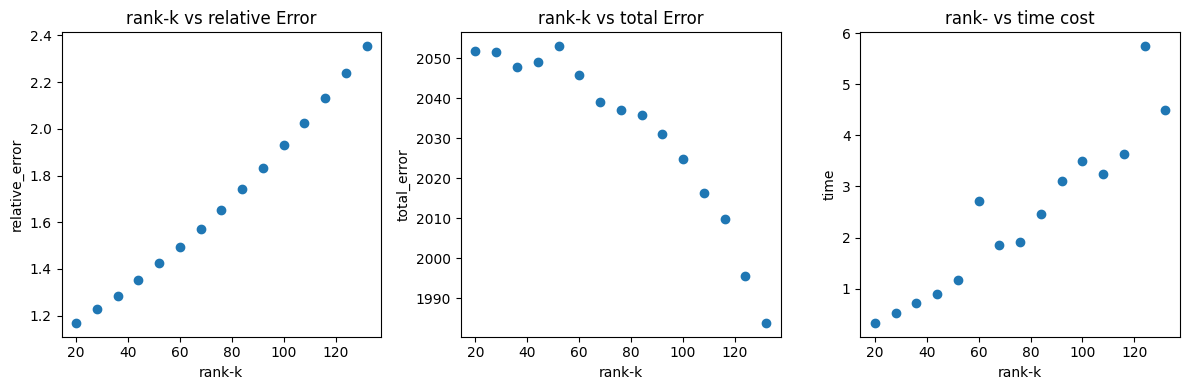

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].scatter(k_lst, r_error)
axs[0].set_xlabel('rank-k')
axs[0].set_ylabel('relative_error')
axs[0].set_title('rank-k vs relative Error')

axs[1].scatter(k_lst, t_error)
axs[1].set_xlabel('rank-k')
axs[1].set_ylabel('total_error')
axs[1].set_title('rank-k vs total Error')

axs[2].scatter(k_lst, time_cost)
axs[2].set_xlabel('rank-k')
axs[2].set_ylabel('time')
axs[2].set_title('rank- vs time cost')

plt.tight_layout()
plt.show()

In [ ]:
k = int(0.06*d)
print(k)
p_error = []
p_lst = [round(1+0.1*i,1) for i in range(11)]
time_cost = []
for p in p_lst:
  time_start = time.time()
  M = algorithm1(A,p,k,delta,epsilon,s,t,phi,psi)
  time_end = time.time()
  p_error.append(relative_error(A,U_A,S_A,V_A_T, M))
  time_cost.append(time_end-time_start)

120


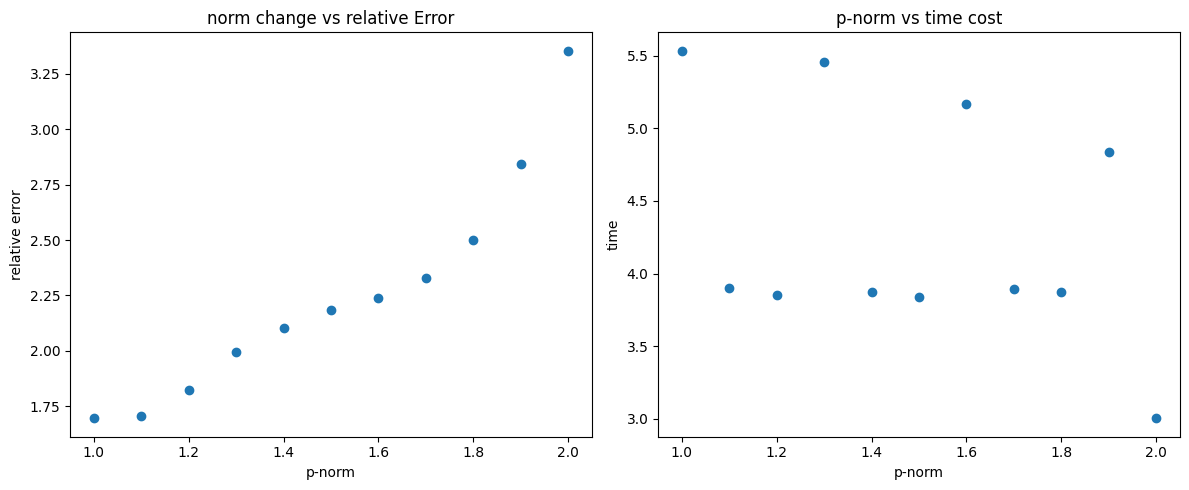

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].scatter(p_lst, p_error)
axs[0].set_xlabel('p-norm')
axs[0].set_ylabel('relative error')
axs[0].set_title('norm change vs relative Error')

axs[1].scatter(p_lst, time_cost)
axs[1].set_xlabel('p-norm')
axs[1].set_ylabel('time')
axs[1].set_title('p-norm vs time cost')

plt.tight_layout()
plt.show()

In [ ]:
p = 1.2
delta_error = []
d_lst = [round(0.01+i*0.005, 3) for i in range(15)]
time_cost = []
for delta in d_lst:
  time_start = time.time()
  M = algorithm1(A,p,k,delta,epsilon,s,t,phi,psi)
  time_end = time.time()
  delta_error.append(relative_error(A,U_A,S_A,V_A_T, M))
  time_cost.append(time_end-time_start)

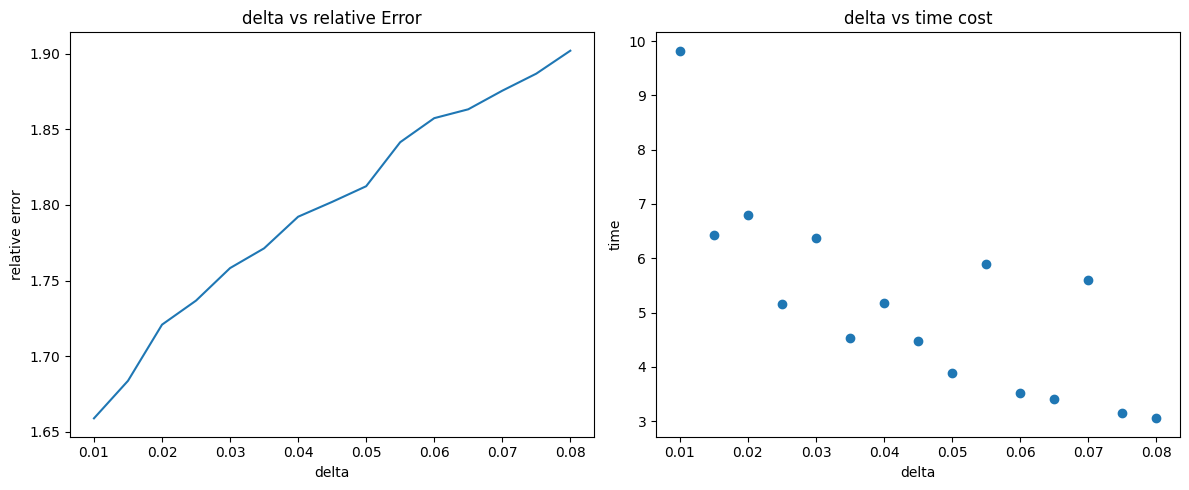

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(d_lst, delta_error)
axs[0].set_xlabel('delta')
axs[0].set_ylabel('relative error')
axs[0].set_title('delta vs relative Error')

axs[1].scatter(d_lst, time_cost)
axs[1].set_xlabel('delta')
axs[1].set_ylabel('time')
axs[1].set_title('delta vs time cost')

plt.tight_layout()
plt.show()

In [ ]:
delta = 0.05
st_lst = [0.1+i*0.02 for i in range(17)]
time_cost = []
st_error = []
for s_t in st_lst:
  time_start = time.time()
  M = algorithm1(A,p,k,delta,epsilon,s_t,s_t,phi,psi)
  time_end = time.time()
  st_error.append(relative_error(A,U_A,S_A,V_A_T, M))
  time_cost.append(time_end-time_start)

In [ ]:
#for i in st_lst:
 # print(int(i*k*np.log(k)*np.log(1/delta)))

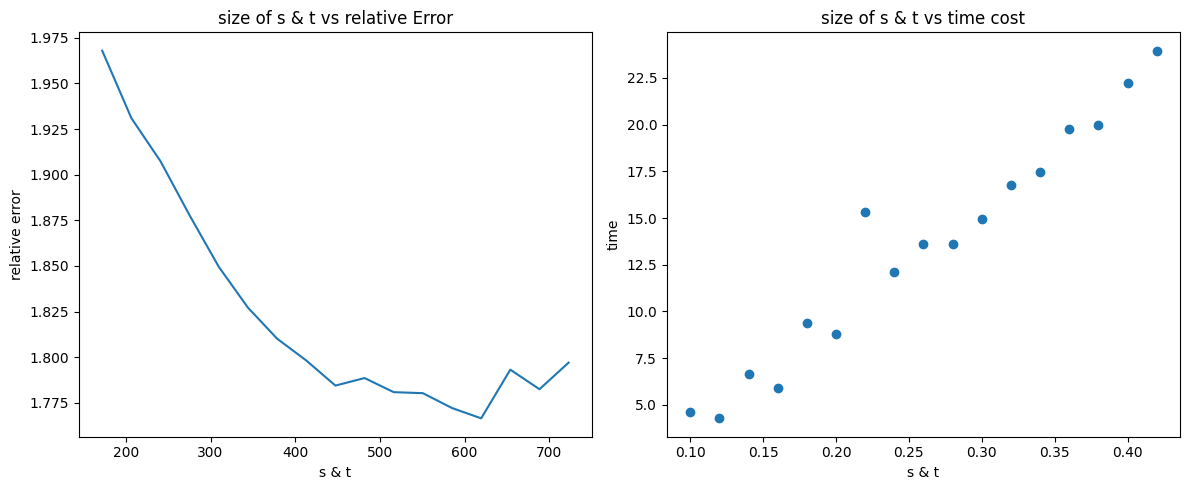

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(list(map(lambda x: x*k*np.log(k)*np.log(1/delta),st_lst)), st_error)
axs[0].set_xlabel('s & t')
axs[0].set_ylabel('relative error')
axs[0].set_title('size of s & t vs relative Error')

axs[1].scatter(st_lst, time_cost)
axs[1].set_xlabel('s & t')
axs[1].set_ylabel('time')
axs[1].set_title('size of s & t vs time cost')

plt.tight_layout()
plt.show()

In [ ]:
#int(0.25*k*np.log(k)*np.log(1/delta))

In [ ]:
s_t = 0.25
time_cost = []
PhiPsi_lst = [0.8+i*0.2 for i in range(17)]
PhiPsi_error = []
for phi_psi in PhiPsi_lst:
  time_start = time.time()
  M = algorithm1(A,p,k,delta,epsilon,s_t,s_t,phi_psi,phi_psi)
  time_end = time.time()
  PhiPsi_error.append(relative_error(A,U_A,S_A,V_A_T, M))
  time_cost.append(time_end-time_start)

In [ ]:
#for i in PhiPsi_lst:
 # print(int(i*k*np.log(k)*np.log(1/delta)))

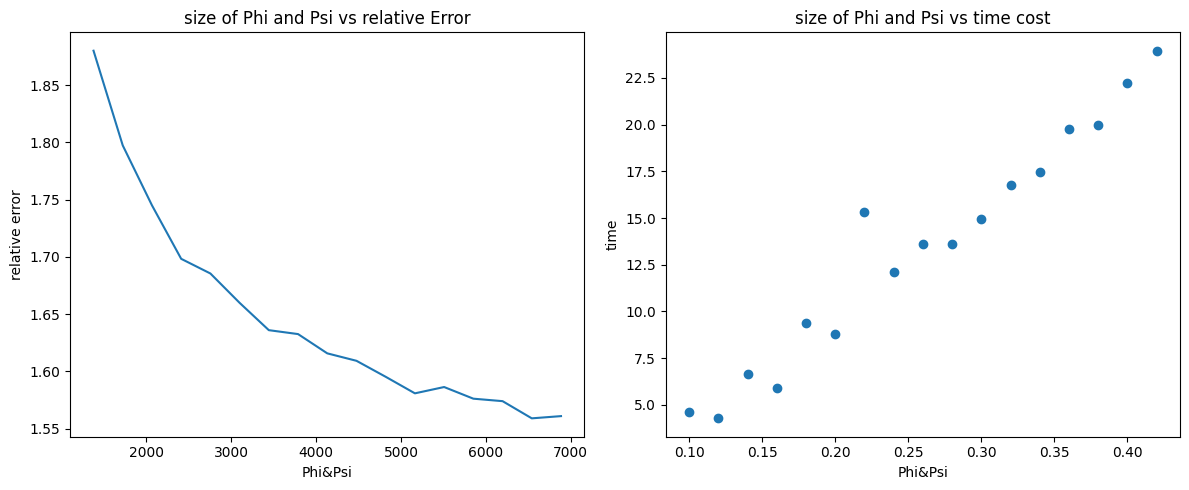

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(list(map(lambda x: x*k*np.log(k)*np.log(1/delta),PhiPsi_lst)), PhiPsi_error)
axs[0].set_xlabel('Phi&Psi')
axs[0].set_ylabel('relative error')
axs[0].set_title('size of Phi and Psi vs relative Error')

axs[1].scatter(st_lst, time_cost)
axs[1].set_xlabel('Phi&Psi')
axs[1].set_ylabel('time')
axs[1].set_title('size of Phi and Psi vs time cost')

plt.tight_layout()
plt.show()

In [ ]:
!pip install pillow

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

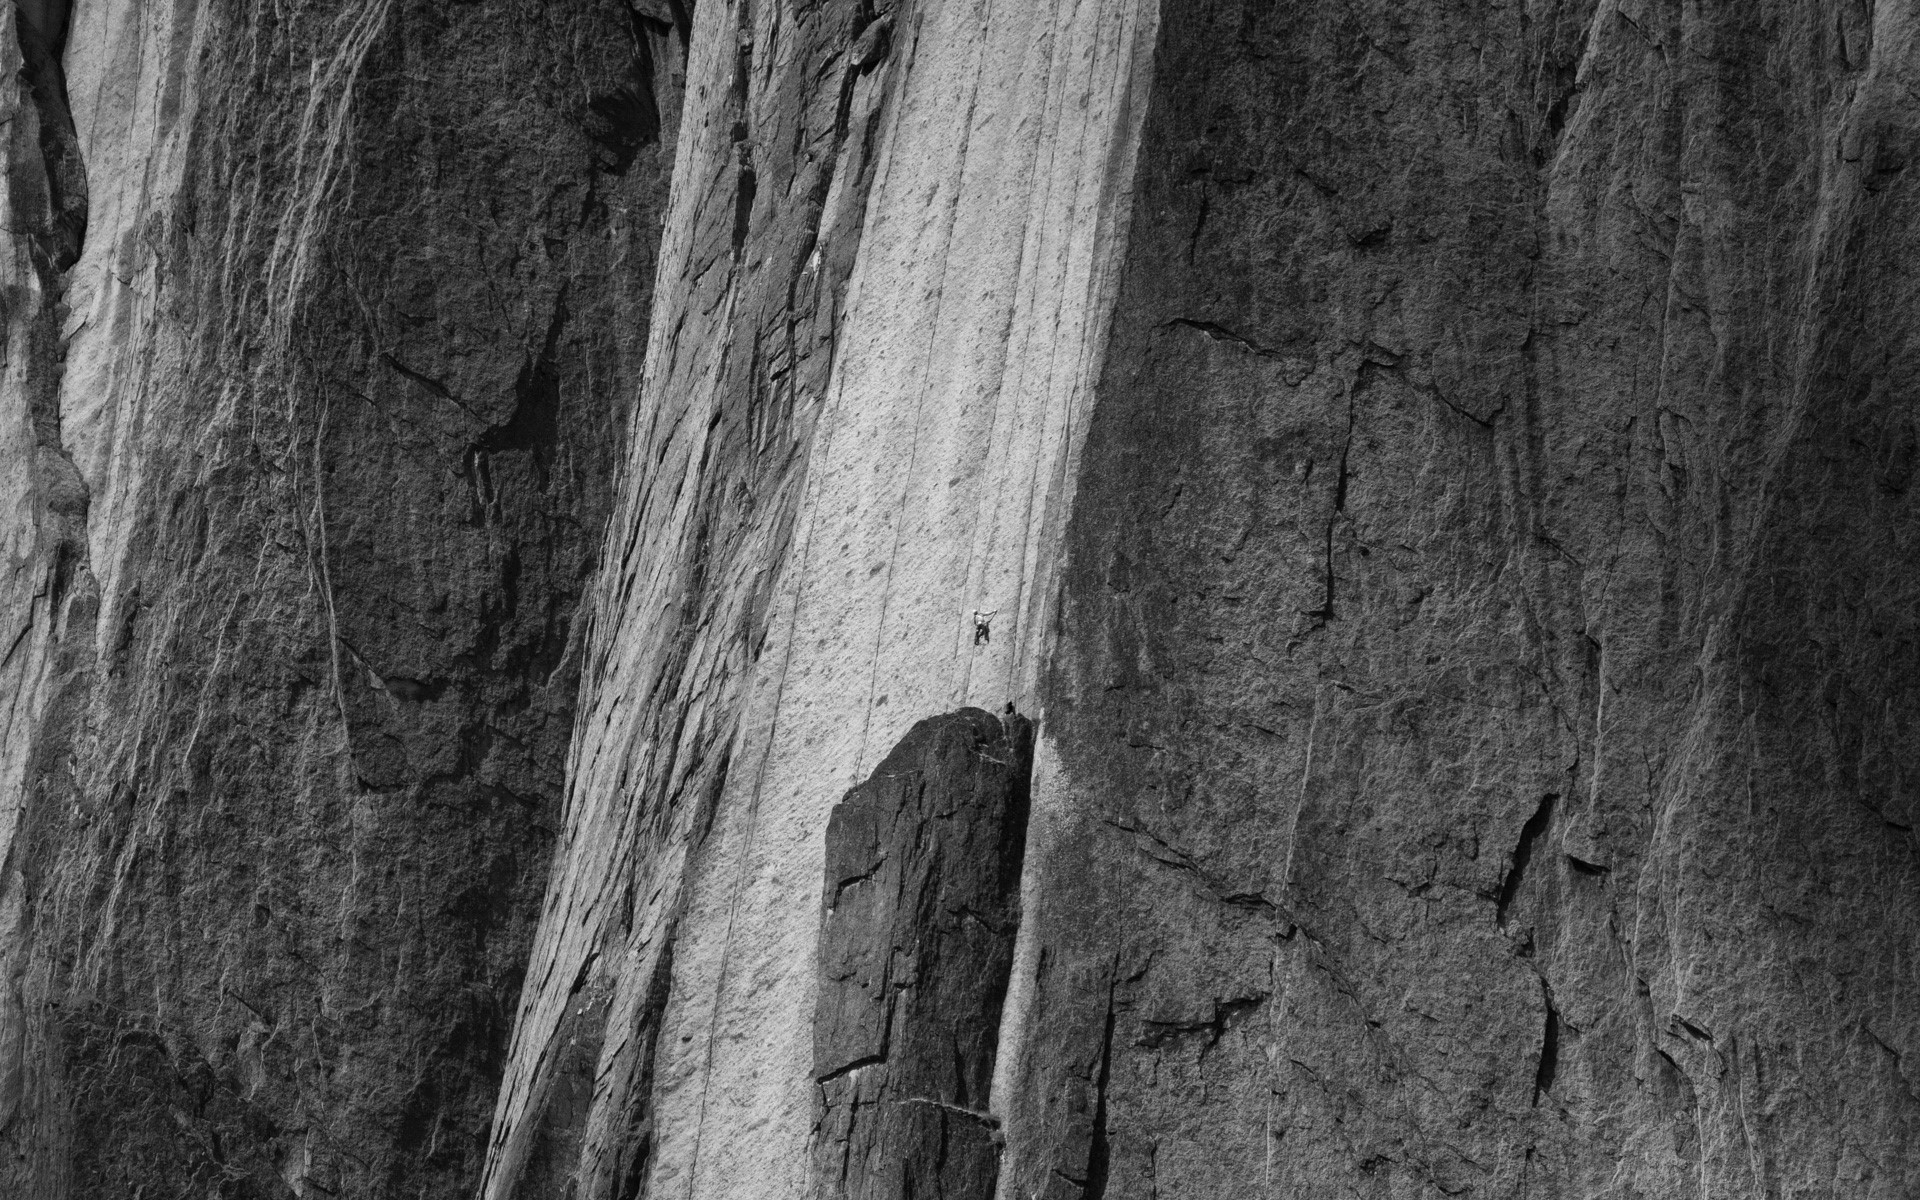

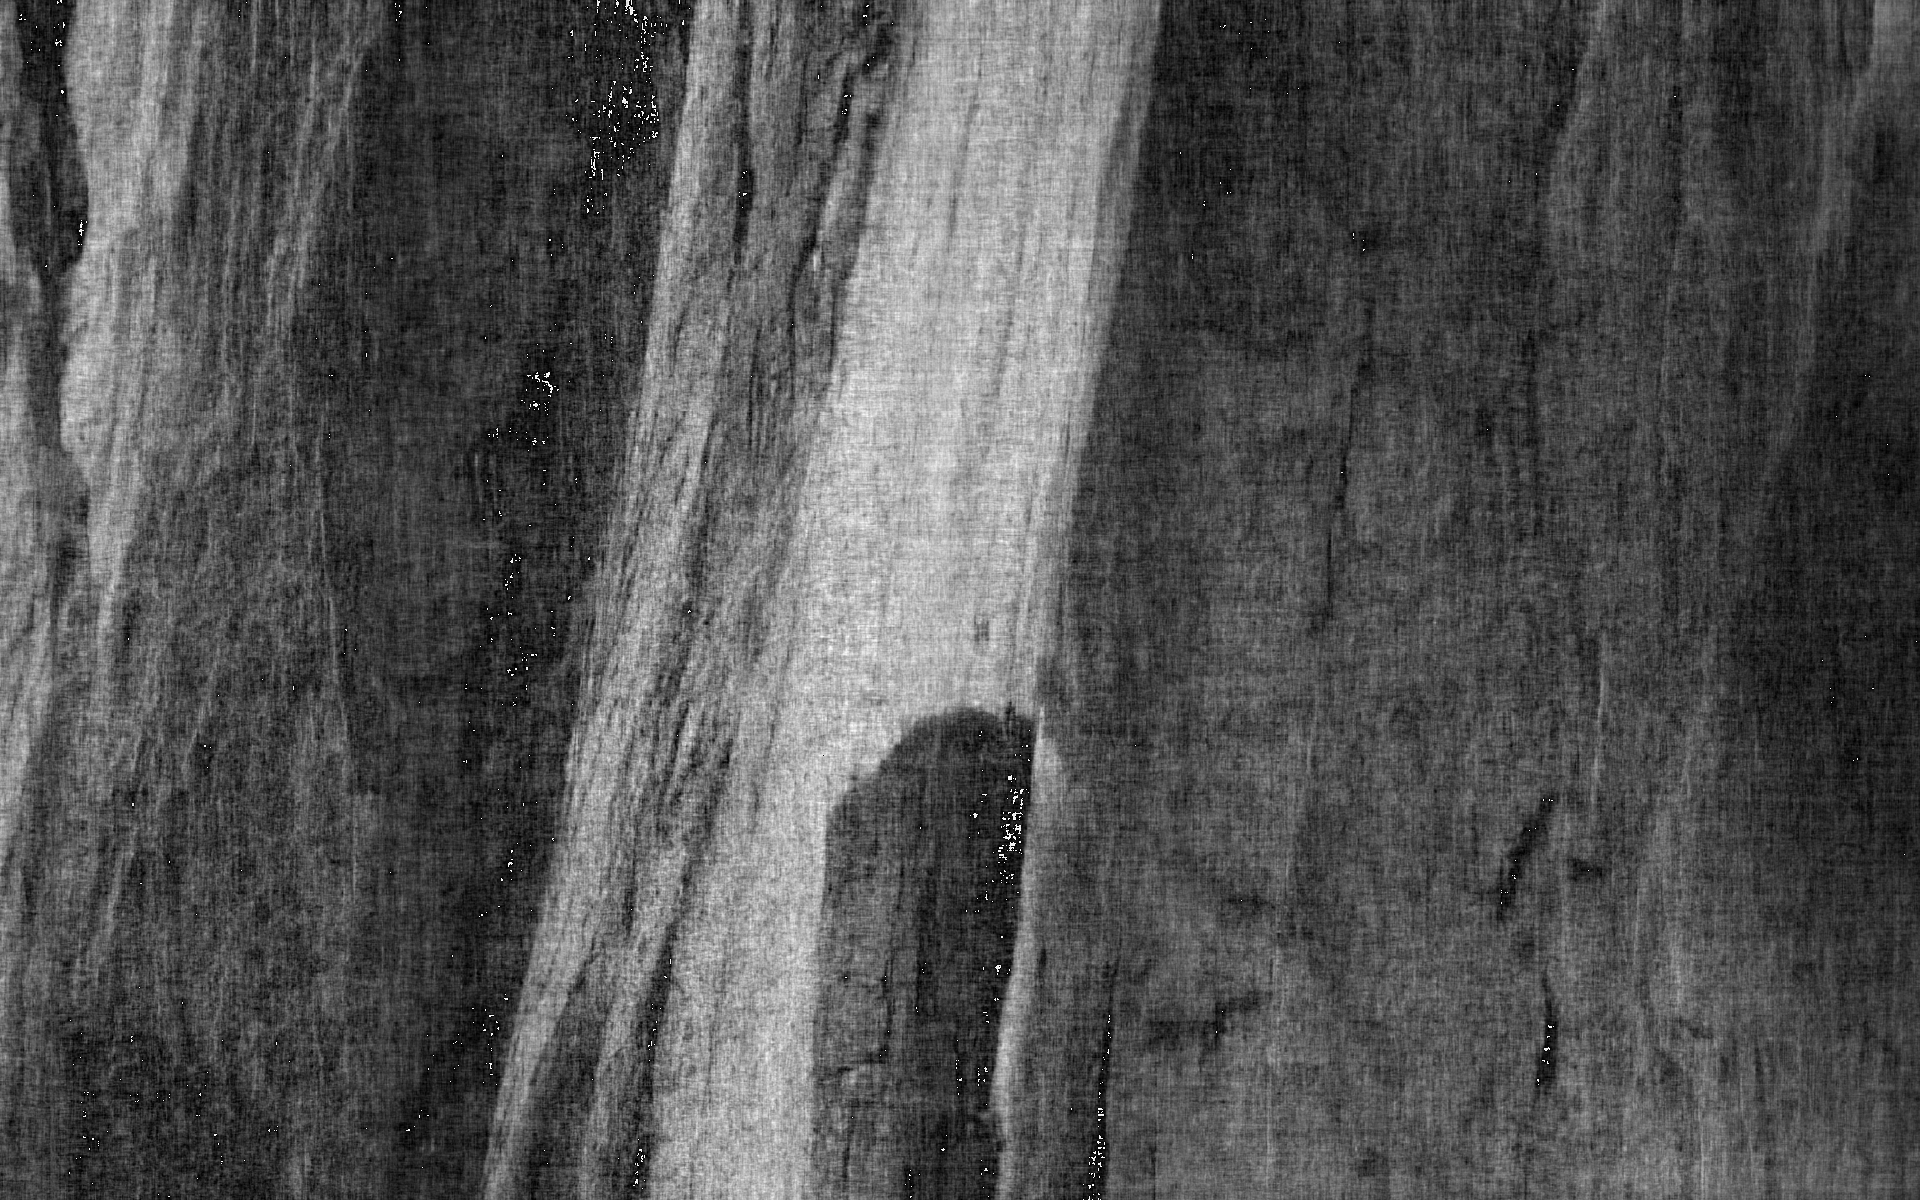

In [ ]:
img = np.array(Image.open('/content/img3.jpg'))
A = img[:,:,0]
display(Image.fromarray(A))
M = algorithm1(A,p,k,delta,epsilon,s,t,phi,psi)
display(Image.fromarray(M.astype(np.uint8)))